In [1]:
# Loading few necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pylab
from scipy.stats import kstest, boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor, make_column_transformer
from sklearn.base import TransformerMixin, BaseEstimator
from mlxtend.feature_selection import ColumnSelector
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import BayesianRidge

## Loading Data

In [2]:
data = pd.read_csv('C:/Users/CHARLIE/anaconda3/HAMOYE/open source project/01-University-Admissions/data/Admission_Predict_Ver1.1.csv')
print(data.shape)

(500, 9)


In [3]:
# Splitting into train and test
train = data.iloc[:400, :]
test = data.iloc[400:, :]
print(train.shape)
print(test.shape)

(400, 9)
(100, 9)


In [4]:
train.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [5]:
# Splitting into features and Targets
X = train.drop(['Chance of Admit '], axis=1)
y = train['Chance of Admit ']

In [6]:
# Selecting only numeric features to test for normality
num_df = train.drop(['University Rating', 'Research', 'Chance of Admit '], axis=1)

## Checking for normality using QQ plots

Q-Q Plot for Serial No.


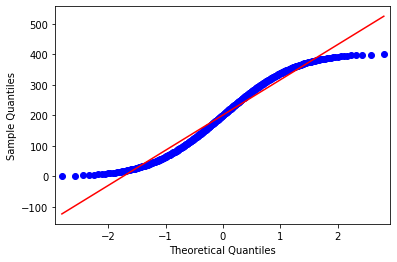

Q-Q Plot for GRE Score


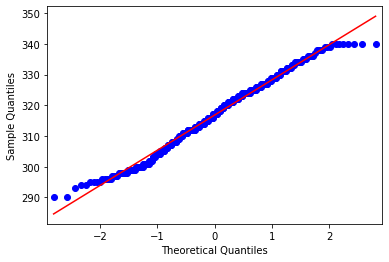

Q-Q Plot for TOEFL Score


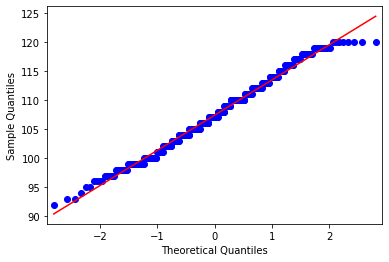

Q-Q Plot for SOP


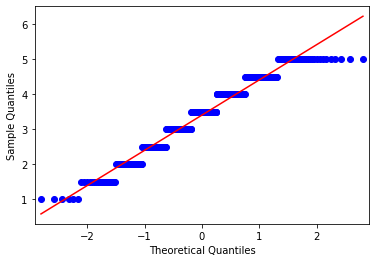

Q-Q Plot for LOR 


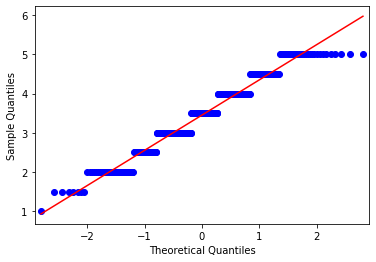

Q-Q Plot for CGPA


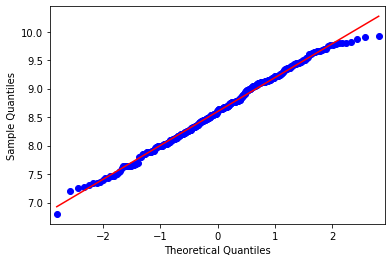

In [7]:
for cols in num_df.columns:
    print(f'Q-Q Plot for {cols}')
    sm.qqplot(num_df[cols], line='s')
    pylab.show()

## Testing for Normality using Kolmogorov's Test

In [8]:
# #Kolmogorov Smirnov Test for Normality
feature_list = list(num_df.columns)
for feature in feature_list:
    output = kstest(num_df[feature], 'norm', N=100)
    print(f'Kolmogorov Test for {feature} = {output}')

Kolmogorov Test for Serial No. = KstestResult(statistic=0.9936501019683699, pvalue=0.0)
Kolmogorov Test for GRE Score = KstestResult(statistic=1.0, pvalue=0.0)
Kolmogorov Test for TOEFL Score = KstestResult(statistic=1.0, pvalue=0.0)
Kolmogorov Test for SOP = KstestResult(statistic=0.9181927987311419, pvalue=0.0)
Kolmogorov Test for LOR  = KstestResult(statistic=0.9572498680518208, pvalue=0.0)
Kolmogorov Test for CGPA = KstestResult(statistic=0.9999999999947691, pvalue=0.0)


We can notice that the p-value of all numeric features are less than 0.05 <br>
Therefore, we will carry out a power transform in our pipeline to make them normal or almost normal.

## Creating Pipeline

In [9]:
# Function for transforming target variable
def func(target):
    print('Target Transform Called')
    target_ = target.copy()
#     print(target.shape)
    target_ = target_.flatten()
#     print(target_.shape)
    target_ = boxcox(target_, lmbda=1.6132074271235903)
    tar = target_.reshape(-1,1)
    return tar

# Function for reversing the transform performed on the target vatiable
def invboxcox(target):
    print('Inverse Target Transform Called')
    ld = 1.6132074271235903
    return(np.exp(np.log(ld*target+1)/ld))

In [10]:
# Custom transformer for changing data type of some features in the pipeline
class Typ_conv(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        cols = ['University Rating', 'Research']
        for col in cols:
            X[col] = X[col].astype('object')
        V = pd.DataFrame(X)
        V.head(3)
        return X.values


In [11]:
# Creating transformer for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('power_transform', PowerTransformer(method='box-cox'))])

# Creating transformer for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# This selector allows the pipeliine select only specified features 
selector = make_pipeline(ColumnSelector(cols=([1,2,3,4,5,6,7])))


In [12]:
# Indices of Numeric Features
numeric_features = [0,1,3,4,5]
# Indices of Categorical Features
categorical_features = [2,6]
# Creating custom transformer for numerical and categorical features
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('cat', categorical_transformer, categorical_features)])


In [13]:
# Combining all transformers into a single pipeline
pipe = Pipeline(steps=[('tconv', Typ_conv()), ('select', selector), ('preprocessor', preprocessor), ('reg', BayesianRidge())])

# We use Transformed Target Regressor because we are performing some transformation on the target variable
model = TransformedTargetRegressor(regressor=pipe,func=func,inverse_func=invboxcox)


In [14]:
X.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,1,337,118,4,4.5,4.5,9.65,1
1,2,324,107,4,4.0,4.5,8.87,1
2,3,316,104,3,3.0,3.5,8.00,1
3,4,322,110,3,3.5,2.5,8.67,1
4,5,314,103,2,2.0,3.0,8.21,0


In [15]:
model.fit(X, y)

Target Transform Called
Inverse Target Transform Called
Target Transform Called
Inverse Target Transform Called
Target Transform Called


TransformedTargetRegressor(check_inverse=True,
                           func=<function func at 0x000002D52152D318>,
                           inverse_func=<function invboxcox at 0x000002D5215008B8>,
                           regressor=Pipeline(memory=None,
                                              steps=[('tconv', Typ_conv()),
                                                     ('select',
                                                      Pipeline(memory=None,
                                                               steps=[('columnselector',
                                                                       ColumnSelector(cols=[1,
                                                                                            2,
                                                                                            3,
                                                                                            4,
                                                      

In [16]:
test.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
400,401,304,100,2,3.5,3.0,8.22,0,0.63
401,402,315,105,2,3.0,3.0,8.34,0,0.66
402,403,324,109,3,3.5,3.0,8.94,1,0.78
403,404,330,116,4,4.0,3.5,9.23,1,0.91
404,405,311,101,3,2.0,2.5,7.64,1,0.62


In [17]:
# Normally, new/test data does not contain the target variable, so we drop it from the test in order to use the trained model on it
x_test = test.drop(['Chance of Admit '], axis=1)

In [18]:
prediction = model.predict(x_test)

Inverse Target Transform Called


In [19]:
prediction

array([0.60746079, 0.66037657, 0.78176475, 0.85905402, 0.5732928 ,
       0.5051262 , 0.65610726, 0.61577319, 0.58414035, 0.57533739,
       0.54873058, 0.55737074, 0.60964255, 0.61011139, 0.74476455,
       0.79547067, 0.61964409, 0.55574943, 0.65556125, 0.63254697,
       0.49876126, 0.81583233, 0.79359983, 0.95034593, 0.915321  ,
       0.94323923, 0.7283259 , 0.7419347 , 0.7324309 , 0.89412512,
       0.66402093, 0.77512695, 0.84633128, 0.75564428, 0.62268069,
       0.5941407 , 0.60764845, 0.64427193, 0.75651767, 0.6684672 ,
       0.53641445, 0.78999816, 0.90021189, 0.8699134 , 0.89040233,
       0.88823404, 0.93070471, 0.81442787, 0.76411054, 0.76812386,
       0.81242921, 0.86164196, 0.89283069, 0.75539995, 0.62354954,
       0.53364801, 0.53160405, 0.48689216, 0.70257833, 0.8622678 ,
       0.76898923, 0.60467743, 0.60871922, 0.59119222, 0.45343769,
       0.64442195, 0.74878284, 0.79833558, 0.82361124, 0.8397    ,
       0.8588325 , 0.64088912, 0.89766309, 0.64108266, 0.62775

In [20]:
## checking rmse between target variable in main scale
main_test_rmse = np.sqrt(mean_squared_error(test['Chance of Admit '], prediction))
print(f'Final RMSE value on test data = {main_test_rmse}')

Final RMSE value on test data = 0.04212006916395779


## Model Weights

In [21]:
# To get the intercept of our model
intercept = model.regressor_.named_steps['reg'].intercept_

In [ ]:
# x_test.head()

In [22]:
# To get the coeffieients of the features of our model
weights = list(model.regressor_.named_steps['reg'].coef_)

# Insert the intercept into the list of coefficients
weights.insert(0, intercept)


In [23]:
weights_df = pd.DataFrame({'Features':['Intercept','GRE Score', 'TOEFL Score', 'SOP', 'LOR ', 'CGPA','University Rating_1',
                                       'University Rating_2', 'University Rating_3', 'University Rating_4',
                                       'University Rating_5', 'Research_0', 'Research_1'], 'Coefficients':weights})

In [24]:
weights_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12
Features,Intercept,GRE Score,TOEFL Score,SOP,LOR,CGPA,University Rating_1,University Rating_2,University Rating_3,University Rating_4,University Rating_5,Research_0,Research_1
Coefficients,-0.242139,0.0170194,0.0156966,-1.84191e-05,0.0152152,0.0534389,0.00408189,-0.00978257,-0.00849277,-0.00181939,0.0160128,-0.0101093,0.0101093


## Prediction Classifier

In [25]:
final_pred = pd.DataFrame(prediction,columns = ["predictions"], index = None)

In [26]:
# We create a classifier for the predicted values
final_pred['result'] = np.where(final_pred['predictions'] >= 0.72, 'you have a high chance of admit','your chances of admit is low')
final_pred.head()


,predictions,result
0,0.607461,your chances of admit is low
1,0.660377,your chances of admit is low
2,0.781765,you have a high chance of admit
3,0.859054,you have a high chance of admit
4,0.573293,your chances of admit is low
